# Intent de detecció de tapes de clavagueres

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
#%matplotlib notebook

Carreguem el vídeo i n'extreiem alguns frames. Això està fet agafant el vídeo, s'haria de mirar com fer-ho per obrir l'stream de càmera.

In [4]:
im = cv2.imread("images_full/frame6.jpg")
im.shape

(1080, 1920, 3)

In [5]:
@interact
def undistort_camera(name=os.listdir('images_full/'), k=1000, a=-0.54, b=0.28, c=0., d= 0., e=0.):
    im = cv2.imread('images_full/' + name)
    height, width = im.shape[:2]
    K = np.eye(3)
    K[0,0] = K[1,1] = k
    K[0:2, 2] = (width-1)/2.0, (height-1)/2.0

    # Distortion coeffitients, same as above
    distorsion_coefs = np.float32([a, b, c, d, e])
    undistorted_im = cv2.undistort(im, K, distorsion_coefs) #-0.2 a full, -0.7 half
    
    img = cv2.cvtColor(undistorted_im, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(9.5, 6))
    plt.imshow(img)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnbmFtZScsIG9wdGlvbnM9KCdmcmFtZTEwNy5qcGcnLCAnZnJhbWUxMjAuanBnJywgJ2ZyYW1lMzUuanBnJywgJ2bigKY=


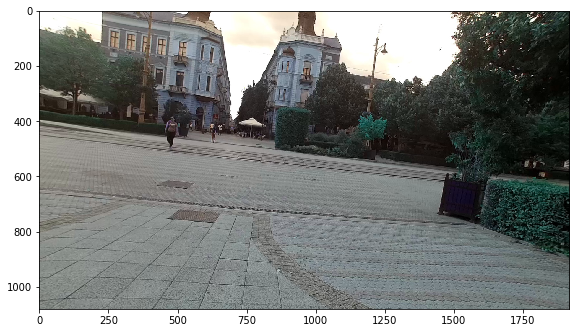

In [7]:
height, width = im.shape[:2]

# K is the camera parameters matrix. We dont have them so we just take a sensible ones.
K = np.eye(3)
K[0,0] = K[1,1] = 1000
K[0:2, 2] = (width-1)/2.0, (height-1)/2.0

# Distortion coeffitients, obtained above
distorsion_coefs = np.float32([-0.2, 0., 0., 0., 0.])

# Undistort
undistorted_im = cv2.undistort(im, K, distorsion_coefs)
undistortedim = cv2.cvtColor(undistorted_im, cv2.COLOR_BGR2RGB)
# Show images
plt.figure(figsize=(9.5, 6))
plt.imshow(undistorted_im)

In [8]:
#Tot això no funciona gaire bé, la calculada a mà és molt millor!

model_pts = np.float32([
    [0,  1080],
    [1920, 1080],
    [0,  0.],
    [1920, 0]])


sqr_size = 150


tl_x = 1000
tl_y = 1000
tr_x = tl_x + sqr_size
tr_y = tl_y
bl_x = tl_x
bl_y = tl_x + sqr_size
br_x = bl_x + sqr_size
br_y = bl_y




model_pts = np.float32([
    [bl_x, bl_y],
    [br_x, br_y],
    [tl_x, tl_y],
    [tr_x, tr_y]
])


impts_undist = np.float32([
    [ 0, 770],
    [ 770, 800],
    [ 686, 536],
    [ 800, 546]])

impts_undist = np.float32([
    [ 29, 973],
    [ 483, 970],
    [ 278, 832],
    [ 571, 861]])

H = cv2.getPerspectiveTransform(impts_undist, model_pts) 

In [9]:
# Calculem-la a mà, a veure si millora...

H = np.float32([[-1.11820478e+00, -1.44434783e+00,  1.22173190e+03],
 [ 1.15380049e+00, -1.00482878e+01,  4.57791522e+03],
 [ 5.96037882e-04, -3.75442027e-03,  1.00000000e+00]])



In [10]:
topdown = cv2.warpPerspective(undistorted_im, H, dsize=(3000, 2200))

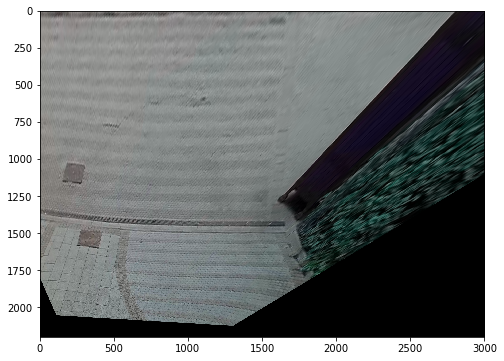

In [11]:
plt.figure(figsize=(9.5, 6))
plt.imshow(topdown)

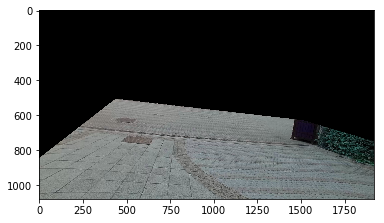

In [12]:
#I si volem recuperar la posició de qualsevol cosa, fem la inversa:

H_inv = homography_inverse = np.linalg.inv(H)
back = cv2.warpPerspective(topdown, H_inv, dsize=(1920, 1080)) #Això torna a ser el retall de la original.
plt.imshow(back)

### Detecció de clavagueres

#### Per color HSV

In [18]:
im_hsv = cv2.cvtColor(topdown,  cv2.COLOR_BGR2HSV)

@interact
def filter_color(name=os.listdir('images_full/'), 
                 h=widgets.IntRangeSlider(value=[0, 179],min=0,max=179,step=1, description='Hue:'),
                 s=widgets.IntRangeSlider(value=[0, 255],min=0,max=255,step=1, description='Sat:'), 
                 v=widgets.IntRangeSlider(value=[0, 255],min=0,max=255,step=1, description='Val:')):
    im = cv2.imread('images_full/' + name)
    im = cv2.undistort(im, K, distorsion_coefs)
    im = cv2.warpPerspective(im, H, dsize=(3000, 2200))
    im_hsv = cv2.cvtColor(im,  cv2.COLOR_BGR2HSV)
    lower1 = np.array([h[0], s[0], v[0]])
    upper1 = np.array([h[1], s[1], v[1]])

    mask = cv2.inRange(im_hsv, lower1, upper1)
  
    plt.imshow(mask)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnbmFtZScsIG9wdGlvbnM9KCdmcmFtZTEwNy5qcGcnLCAnZnJhbWUxMjAuanBnJywgJ2ZyYW1lMzUuanBnJywgJ2bigKY=


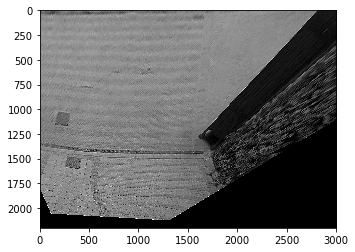

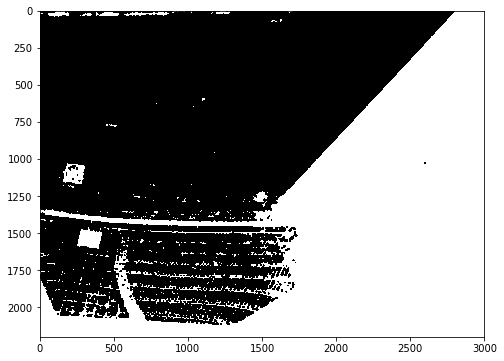

In [25]:
gray = cv2.cvtColor(topdown, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

plt.imshow(sharpen, cmap='gray')

_, thresh = cv2.threshold(sharpen, 95, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#close = cv2.morphologyEx(thresh, cv.MORPH_DILATE, kernel, iterations=2)
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
close = cv2.medianBlur(close, 7)


plt.figure(figsize=(9.5, 6))
plt.imshow(close, cmap='gray')

In [26]:
def areaFilter(minArea, inputImage):

    # Perform an area filter on the binary blobs:
    componentsNumber, labeledImage, componentStats, componentCentroids = \
    cv2.connectedComponentsWithStats(inputImage, connectivity=4)

    # Get the indices/labels of the remaining components based on the area stat
    # (skip the background component at index 0)
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]

    # Filter the labeled pixels based on the remaining labels,
    # assign pixel intensity to 255 (uint8) for the remaining pixels
    filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')

    return filteredImage

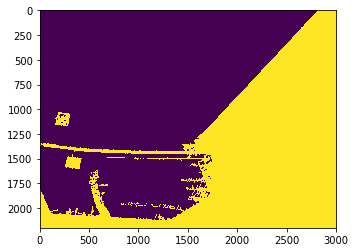

In [27]:
minArea = 5000 #Inicialment era 12000
close_filt = areaFilter(minArea, close)
plt.imshow(close_filt)
#th2 = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
#plt.imshow(sharpen, cmap='gray')

3
(248, 1458, 173, 151, 16552.0, 1.1456953642384107)
(151, 1030, 154, 144, 16207.5, 1.0694444444444444)
(0, 0, 3000, 2200, 2649383.5, 1.3636363636363635)


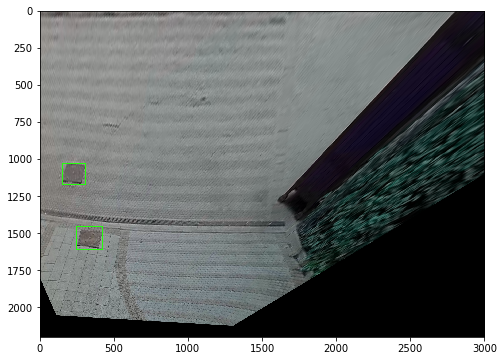

In [29]:
cnts = cv2.findContours(close_filt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

print(len(cnts))

min_area = 12000
max_area = 100000
image_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    x,y,w,h = cv2.boundingRect(c)
    aspect_ratio = float(w)/h
    print(x,y,w,h, area, aspect_ratio)
    #if area > min_area and area < max_area:
    if aspect_ratio > 0.8 and aspect_ratio < 1.5 and area < max_area:
        ROI = topdown[y:y+h, x:x+w]
        cv2.rectangle(topdown, (x, y), (x + w, y + h), (36,255,12), 5)
        image_number += 1

plt.figure(figsize=(9.5, 6))
plt.imshow(topdown)

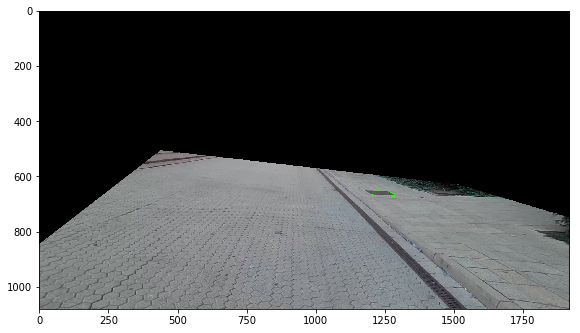

In [18]:
back = cv2.warpPerspective(topdown, H_inv, dsize=(1920, 1080))
plt.figure(figsize=(9.5, 6))
plt.imshow(back)